In [17]:
import sys
sys.path.append("..")
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
import json
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
font = {'family' : 'STIXGeneral',
        'size'   : 15}
matplotlib.rc('font', **font)

from occrx.occParams import OCCSystemParams, OCCTestParams, OCCTxParams, OCCRxParams, OCCChannelParams
from occscripts.occscriptutils import Circle, Rectangle
from occscripts.testdetection import DetectionResults
from occscripts.testcalibration import CalibrationResults
from occscripts.testdecoding import DecodingResults

def transformCirclePoints(circle, radius):
    return Circle((radius,radius),circle.radius)
def translatePoints(oldCirclePoint,newCirclePoint,points):
    dx,dy = oldCirclePoint - newCirclePoint
    return (points[0]-dx, points[1]-dy)
def drawCircleMatrix(width,height,circle):
    xx, yy = np.mgrid[:height, :width]
    circleMatrix = (xx - circle.centroid[1]) ** 2 + (yy - circle.centroid[0]) ** 2
    return np.repeat(np.expand_dims(((np.logical_and(circleMatrix < circle.radius ** 2, circleMatrix > 0)).astype(np.int))*255,axis=2),3,axis=2)

tests = {
    "detection":"detectiontests",
    "calibration":"calibration",
    "decoding":"decoding"
}
def getTestFolder(baseFolder,frequency,distance,testType,testNumber):
    return baseFolder+'/f{}_s1920.0x1080.0_fps30.0_g75.0_wb6500_exp3.0_distance{}cm'.format(frequency,distance)\
                        +'/{}/test{}'.format(tests[testType],testNumber)

def getParamsForTest(testFolder):
    
    occSystemParams = OCCSystemParams()
    occTestParams = OCCTestParams()
    occDetetionCircle = Circle()
    occDetectionResults = DetectionResults()
    occCalibrationResults = CalibrationResults()
    occDecodingResults = DecodingResults()
    
    try:
        with open(testFolder+"/occsystemparams.json") as json_file:
            occSystemParams.initFromJSON(json.load(json_file))
    except IOError:
        occSystemParams = None
    try:
        with open(testFolder+"/occtestparams.json") as json_file:
            occTestParams.initFromJSON(json.load(json_file))
    except IOError:
        occTestParams = None
    try:
        with open(testFolder+"/circle.json") as json_file:
            occDetetionCircle.initFromJSON(json.load(json_file))
    except IOError:
        occTestParams = None
    try:
        with open(testFolder+"/detectionresults.json") as json_file:
            occDetectionResults.initFromJSON(json.load(json_file))
    except IOError:
        occDetectionResults = None
    try:
        with open(testFolder+"/calibrationresults.json") as json_file:
            occCalibrationResults.initFromJSON(json.load(json_file))
    except IOError:
        occCalibrationResults = None
    try:
        with open(testFolder+"/decodingresults.json") as json_file:
            occDecodingResults.initFromJSON(json.load(json_file))
    except IOError:
        occDecodingResults = None
    
    return occSystemParams,occTestParams,occDetetionCircle,occDetectionResults,occCalibrationResults,occDecodingResults

In [2]:
baseFolder = '../videos/validation2/f3240'
frequency = 3240
distance = 55
detectionTestNumber = 0

occSystemParams40,\
occTestParams40,\
occDetetionCircle40,\
occDetectionResults40,\
occCalibrationResults40,\
occDecodingResults40 = getParamsForTest(getTestFolder(baseFolder,frequency,distance,"detection",detectionTestNumber))

In [15]:
# from sklearn.utils.fixes import signature

def plotHistogram(ax, detectionResults):
    nG = np.sum(np.array(detectionResults.isWithinCircle).astype(np.int))
    nNG = np.sum(np.logical_not(np.array(detectionResults.isWithinCircle)).astype(np.int))
    nT = nG+nNG
    pOK = nG/nT
    pNOK = nNG/nT
    
    genuineMaxValues = np.array(detectionResults.maxValues)[detectionResults.isWithinCircle]
    nongenuineMaxValues = np.array(detectionResults.maxValues)[np.logical_not(detectionResults.isWithinCircle)]
    histG, binsG  = np.histogram(genuineMaxValues, density=True, bins=100)
    histNG, binsNG = np.histogram(nongenuineMaxValues, density=True, bins=100)
    ax.plot(binsG[:-1], histG*pOK, color='g', label = 'P(P)={:1.2f}'.format(pOK))
    ax.plot(binsNG[:-1], histNG*pNOK, color='r', label = 'P(N)={:1.2f}'.format(pNOK))
#     ax.set_xlabel(r'$\rho _{max}$', fontsize=15)
    ax.legend(loc = 'lower left')
    ax.set_title("d={}cm".format(distance))
    ax.axvline(x=0.834, color='blue',linestyle='--',alpha=0.75)

def plotROCCurve(ax, detectionResults):
    fpr, tpr, thresholds = metrics.roc_curve(np.array(detectionResults.isWithinCircle).astype(np.int),\
                                             detectionResults.maxValues)
    roc_auc = metrics.auc(fpr, tpr)
    fnr = 1-tpr
    ax.set_title('Receiver Operating Characteristic')
    ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    ax.legend(loc = 'lower right', prop={'size': 20})
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

def plotPRCCurve(ax, detectionResults,distance,index):
    precision, recall, thresholds = metrics.precision_recall_curve(np.array(detectionResults.isWithinCircle).astype(np.int),\
                                         detectionResults.maxValues)
    ax.set_title('Precision/Recall Curve')
    colors = ['g','y','orange','r']
    ax.step(recall, precision,color=colors[index], alpha=0.2,
     where='post', label = 'd = {}cm'.format(distance))
    ax.legend(loc = 'lower left')
#     step_kwargs = ({'step': 'post'}
#            if 'step' in signature(plt.fill_between).parameters
#            else {})
    step_kwargs = {'step': 'post'}
    ax.fill_between(recall, precision, alpha=0.2, color=colors[index], **step_kwargs)
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')

def plotDetectionCircle(ax, circle,referenceCircle,detectionResults):
    width = (referenceCircle.radius + 50)*2
    height = (referenceCircle.radius + 50)*2
    tcircle = transformCirclePoints(circle,referenceCircle.radius + 50)
    pltCircle = drawCircleMatrix(width,height,tcircle)
    f = lambda points: translatePoints(circle.centroid,tcircle.centroid,points)
    tpoints = np.array(list(map(f,detectionResults.maxLoc)))
    x = np.array(tpoints)[:,0]
    y = np.array(tpoints)[:,1]
    genuineMaxValues = np.array(detectionResults.maxValues)[detectionResults.isWithinCircle]
    nongenuineMaxValues = np.array(detectionResults.maxValues)[np.logical_not(detectionResults.isWithinCircle)]

    ax.scatter(x=x[detectionResults.isWithinCircle],\
                y=y[detectionResults.isWithinCircle],\
                s=40,cmap='Greens',\
                c=genuineMaxValues,\
                alpha=1, marker='o')
    ax.scatter(x=x[np.logical_not(detectionResults.isWithinCircle)],\
                y=y[np.logical_not(detectionResults.isWithinCircle)],\
                s=40,cmap='Reds',\
                c=nongenuineMaxValues,\
                alpha=1, marker='x')
    ax.imshow(pltCircle)
    ax.axis('off')

def plotF1Score(detectionResults):
    precision, recall, thresholds = metrics.precision_recall_curve(np.array(detectionResults.isWithinCircle).astype(np.int),\
                                             detectionResults.maxValues)
    F1 = 2 * (precision * recall) / (precision + recall)
    ax.legend(loc = 'lower right')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    ax.plot(F1)

def computeMeanFrames(detection,th,numberOfSamples):
    maxValuesTh = detection.maxValues
    maxValuesTh = np.append(np.array(maxValuesTh),np.array(maxValuesTh))
    indices = np.where(maxValuesTh>=th)[0]
    if(indices.size == 0):
        return np.nan
    framesV = []
    for i in range(0,numberOfSamples):
        index = np.random.randint(0,len(detection.maxValues))
        frames = indices[np.argmax(indices>index)] - index
        framesV.append(frames)
    return framesV

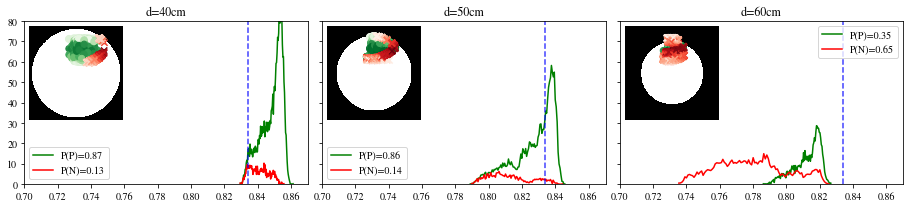

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
baseFolder = '../videos/validation'
frequency = 2160
distance = 40
detectionTestNumber = 0
figCircle, axisCircle=plt.subplots(1,3, figsize=(5.25*3,3),sharey=True)

for index, distance in enumerate([40,50,60]):
    occSystemParams,\
    occTestParams,\
    occDetetionCircle,\
    occDetectionResults,\
    occCalibrationResults,\
    occDecodingResults = getParamsForTest(getTestFolder(baseFolder,frequency,distance,"detection",detectionTestNumber))

    plotHistogram(axisCircle[index], occDetectionResults)
    axisCircle[index].set_ylim([0,80])
    axisCircle[index].set_xlim([0.7,0.87])
    inset_ax = inset_axes(axisCircle[index],
                        width=1.3, # width = 30% of parent_bbox
                        height=1.3, # height : 1 inch
                        loc="upper left")
    plotDetectionCircle(inset_ax, occDetetionCircle, occDetetionCircle40, occDetectionResults)
plt.subplots_adjust(wspace = 0.05,hspace = 0.4)
# axisCircle[0].legend(loc = 'upper right')
# axisCircle[1].legend(loc = 'upper right')
axisCircle[2].legend(loc = 'upper right')
# plt.savefig('./out/histogram4.pdf', bbox_inches='tight')

/home/cristojv/.virtualenvs/occ-rx/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: The 'withdash' parameter of text() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'withdash', they should be pass as keyword, not positionally.
/home/cristojv/.virtualenvs/occ-rx/lib/python3.6/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: 
The TextWithDash class was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Annotation instead.


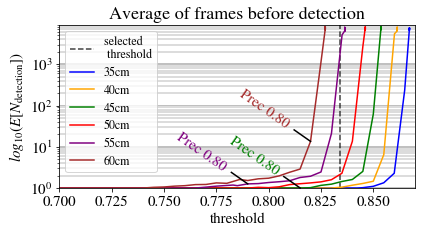

In [29]:
baseFolder = '../videos/validation/'
frequency = 2160
distance = 40
distances = [35,40,45,50,55,60]
detectionTestNumber = 0
fig, ax = plt.subplots(1,figsize=(2.125*3,3))    
detectionResultsV = 0

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if((array[idx]-value)>0.003):
        return value,idx
    return array[idx],idx

preciD = []
threD = []
meanD = []

colors = ['blue','orange','green','red','purple','brown']
ax.axvline(x=0.834, color='black',linestyle='--',alpha=0.75,label="selected \n threshold")
for indexD, distance in enumerate(distances):
    preci = []
    threPreci = []
    meanPreci = []
    # Se obtienen los parametros para la distancia acordada
    occSystemParams,\
    occTestParams,\
    occDetetionCircle,\
    occDetectionResults,\
    occCalibrationResults,\
    occDecodingResults = getParamsForTest(getTestFolder(baseFolder,frequency,distance,"detection",detectionTestNumber))

    # Se obtiene la precision
    precision, recall, thresholds = metrics.precision_recall_curve(np.array(occDetectionResults.isWithinCircle).astype(np.int),\
                                         occDetectionResults.maxValues)
    # Se establecen los thresholds a tener en cuenta
    thresholdsVector = []
    thresholdIndexes = []
    
    for th in np.arange(0.7,0.90,0.005):
        tho,index = find_nearest(thresholds,th)
        thresholdsVector.append(tho)
        thresholdIndexes.append(index)
    # Se miden las precisiones para esos thresholds
    precisionEvaluated = precision[thresholdIndexes]
    
    # Se mide el numero de frames para cada threshold
    meanFramesVector = []
    
    for threshold in thresholdsVector:
        if not threshold==np.nan:
            framesVector = computeMeanFrames(occDetectionResults,threshold,100)
            meanFrames = np.mean(np.array(framesVector))
            varFrames = np.var(np.array(framesVector))
            meanFramesVector.append(meanFrames)
    
    meanFramesVector = np.array(meanFramesVector)
    
    precisionIV = np.arange(0.80, 0.81, 0.10)
    precisionVector = []
    meanVector = []
    th2V = []
    
    for precisionI in precisionIV:
        nearest,indexN = find_nearest(precisionEvaluated,precisionI)
        precisionVector.append(nearest)
        th2V.append(indexN)
    
    ax.plot(thresholdsVector,meanFramesVector,color=colors[indexD], label = '{}cm'.format(distance))
    
    ax.set_title('Average of frames before detection')
    ax.set_ylabel('$log_{10}(E[N_{\mathrm{detection}}]$)')
    ax.set_xlabel('threshold')
    ax.set_xlim([0.70, 0.87])
    ax.set_ylim([1, 9000])
    for th22V in th2V:
        threPreci.append(thresholdsVector[th22V])
        meanPreci.append(meanFramesVector[th22V])
    preciD.append(precisionVector)
    threD.append(threPreci)
    meanD.append(meanPreci)
preciD = np.array(preciD)
threD = np.array(threD)
meanD = np.array(meanD)

for a in range(0,len(threD)):
    for index35, thr35 in enumerate(threD[a,:]):
        if(thr35 > 0.75):
            if(meanD[a,index35]<20):
                ax.text(threD[a,index35],meanD[a,index35],"Prec {:0.2f}".format(preciD[0][index35]),color=colors[a], withdash=True, dashlength=20,rotation=325)
    # ax.legend(loc = 'upper left')
ax.legend(loc = 'upper left', prop={'size': 12})
# ax.set_yscale('log')
plt.yscale('log')
matplotlib.pyplot.grid(b=None, which='major', axis='y',color='#C0C0C0', linestyle='-', linewidth=2)
matplotlib.pyplot.grid(b=None, which='minor', axis='y',color='#DCDCDC', linestyle='-', linewidth=2)
plt.savefig('./out/avg4.pdf', bbox_inches='tight')

In [11]:
import random
baseFolder = '../videos/validation'
frequency = 2160
distance = 40
detectionTestNumber = 0

occSystemParams,\
occTestParams,\
occDetetionCircle,\
occDetectionResults,\
occCalibrationResults,\
occDecodingResults = getParamsForTest(getTestFolder(baseFolder,frequency,distance,"detection",detectionTestNumber))

genuineOcurrences = np.where(np.array(occDetectionResults.isWithinCircle)==True)[0]
randomIndex = random.randint(0,len(genuineOcurrences)-1)
genuineOcurrence = genuineOcurrences[randomIndex]
while(genuineOcurrence > (len(occDetectionResults.isWithinCircle)-171)):
    genuineOcurrence = genuineOcurrence -1
    if(genuineOcurrence<=0):
        break
print(genuineOcurrence)

8781


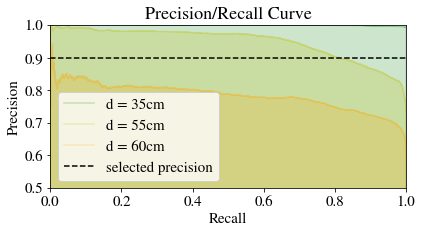

In [21]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
baseFolder = '../videos/validation'
frequency = 2160
distance = 40
detectionTestNumber = 0
figCircle, axisCircle=plt.subplots(1, figsize=(2.125*3,3),sharey=True)

for index, distance in enumerate([35,55,60]):
    occSystemParams,\
    occTestParams,\
    occDetetionCircle,\
    occDetectionResults,\
    occCalibrationResults,\
    occDecodingResults = getParamsForTest(getTestFolder(baseFolder,frequency,distance,"detection",detectionTestNumber))

    plotPRCCurve(axisCircle, occDetectionResults, distance, index)
    axisCircle.set_ylim([0.5,1])
    axisCircle.set_xlim([0,1])
#     inset_ax = inset_axes(axisCircle,
#                         width=2.1, # width = 30% of parent_bbox
#                         height=2.1, # height : 1 inch
#                         loc="upper left")
#     plotDetectionCircle(inset_ax, occDetetionCircle, occDetetionCircle40, occDetectionResults)
plt.subplots_adjust(wspace = 0.05,hspace = 0.4)
axisCircle.axhline(y=0.9, color='black', linestyle='--',label = "selected precision")
axisCircle.legend(loc = 'lower left')
plt.savefig('./out/prc4.pdf', bbox_inches='tight')